<a href="https://colab.research.google.com/github/JMGilbert/STAT4241-Final-Project/blob/main/5241NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Don't forget to enable GPU:    
Edit > Notebook settings or Runtime>Change runtime type    
and select GPU as Hardware accelerator.

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import Data

In [2]:
#url of the dataset from our GitHub repository
url_red="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-red.csv"
url_white="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-white.csv"
red=pd.read_csv(url_red,sep=';')
white=pd.read_csv(url_white,sep=';')

<BarContainer object of 7 artists>

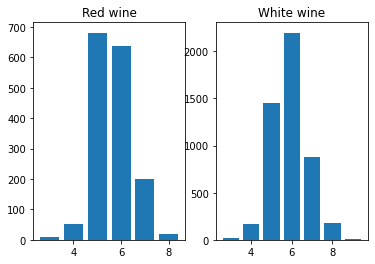

In [3]:
plt.subplot(1,2,1).set_title("Red wine")
plt.bar(list(set(red["quality"])),red["quality"].value_counts(sort=False).sort_index())
plt.subplot(1,2,2).set_title("White wine")
plt.bar(list(set(white["quality"])),white["quality"].value_counts(sort=False).sort_index())

In [4]:
print(white.isnull().values.any())
print(red.isnull().values.any())

False
False


In [5]:
X_white=white.loc[:, white.columns != 'quality']
Y_white=white.loc[:, white.columns == 'quality']
X_red=red.loc[:, red.columns != 'quality']
Y_red=red.loc[:, red.columns == 'quality']

In [6]:
def TO_TORCH(m):
    #convert an array/DF into a tensor with gpu on if necessary
    if isinstance(m, np.ndarray):
        m=torch.from_numpy(m).float()
    elif isinstance(m, pd.DataFrame):
        m=torch.from_numpy(m.values).float()
    elif isinstance(m, pd.Series):
        m=torch.from_numpy(m.values).float()

    if train_on_gpu:
        m = m.to(device="cuda")
    return(m)

In [7]:
red_class=pd.unique(red['quality'])
white_class=pd.unique(white['quality'])
red_class.sort()
white_class.sort()

In [8]:
predictors_name=list(red.columns)[:-1]
predictors_name

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# $\frac{2}{3}$/$\frac{1}{3}$ Holdout Split and Standardization

In [9]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white['quality'], test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red['quality'], test_size=0.33, random_state=42)

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)

# Nerual Networks

## Architecture

? why using one dimensional output 

In [10]:
# Neural Network structure
class Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,DROP_PR=0.0,BN=False):
        super(Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        self.DROP_PR = DROP_PR
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.BN=BN
        self.bn = nn.ModuleList()
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            self.bn.append(nn.BatchNorm1d(hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, self.output_dim))
        self.dropout = nn.Dropout(self.DROP_PR)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.BN:
                x = self.bn[i](x)
            x = torch.sigmoid(x)
            x = self.dropout(x)
        out = self.layers[-1](x)
        return out 

#Loss function: mean absolute deviation
criterion = torch.nn.L1Loss() 

#Accuracy with tolerance
def ACCURACY(Y_pred,target,Tolerance):
    v=(abs(Y_pred-target)<=Tolerance)*1.0
    return(torch.mean(v))

#Kappa statistic compared with a random classifier
def KAPPA(Y_pred,target):
    #only work for Tolerance=0.5
    KAPP=cohen_kappa_score(target.cpu().detach().numpy(),torch.round(Y_pred).cpu().detach().numpy())
    #KAPP2=cohen_kappa_score(torch.round(Y_pred).cpu().detach().numpy(),target.cpu().detach().numpy())    
    return(KAPP)

## Toy example (Ignore this part)
red wine

In [11]:
T=1 #Tolerance:0.25,0.5,1.0

LR=1e-2
OPT="SGD" # "SGD" or "ADAM"
EPOCH=3000

HIDDEN_DIM = [11]
INPUT_DIM = X_TRAIN_white.shape[1]
OUTPUT_DIM = 1
TOY_MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
if train_on_gpu:
    TOY_MODEL.cuda()
#Optimizer: 
if OPT=="SGD":
    optimizer = torch.optim.SGD(TOY_MODEL.parameters(),lr=LR)
if OPT=="ADAM":
    optimizer = torch.optim.Adam(TOY_MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=DECAY)

In [12]:
LOSS_ARR=[]
torch.manual_seed(0)
for epoch in tq(range(EPOCH)):
    optimizer.zero_grad()
    outputs=TOY_MODEL(X_TRAIN_red)[:,0] #prediction
    loss = criterion(outputs, Y_TRAIN_red) #compared with the true labels
    LOSS_ARR.append(loss.data)
    loss.backward()
    optimizer.step()    
    if (epoch+1)%round(EPOCH/5)==0:
        kappa=KAPPA(outputs, Y_TRAIN_red)
        accuracy=ACCURACY(outputs,Y_TRAIN_red,T).item()
        print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))


 25%|██▍       | 747/3000 [00:00<00:02, 1059.13it/s]


 After 600 Epochs: MAD is 0.489; Accuracy is 88.796% (T=1); KAPPA is 32.962% (T=0.5)


 46%|████▋     | 1389/3000 [00:01<00:01, 1061.67it/s]


 After 1200 Epochs: MAD is 0.485; Accuracy is 88.796% (T=1); KAPPA is 32.698% (T=0.5)


 64%|██████▍   | 1929/3000 [00:01<00:00, 1071.77it/s]


 After 1800 Epochs: MAD is 0.483; Accuracy is 89.076% (T=1); KAPPA is 33.946% (T=0.5)


 86%|████████▌ | 2580/3000 [00:02<00:00, 1071.31it/s]


 After 2400 Epochs: MAD is 0.482; Accuracy is 89.076% (T=1); KAPPA is 34.39% (T=0.5)


100%|██████████| 3000/3000 [00:02<00:00, 1059.40it/s]


 After 3000 Epochs: MAD is 0.481; Accuracy is 89.076% (T=1); KAPPA is 34.403% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.4811613857746124')

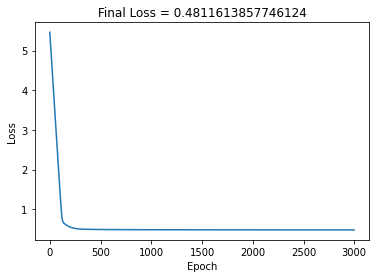

In [13]:
zoom=np.floor(len(LOSS_ARR)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_ARR)-zoom)+zoom, LOSS_ARR[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_ARR[-1]))

In [14]:
test_pred=TOY_MODEL(X_TEST_red)
loss = criterion(test_pred, Y_TEST_red)
print("Test MAD is {};".format(round(loss.item(),3)))
for T in [0.25,0.5,1.0]: 
    accuracy=ACCURACY(test_pred,Y_TEST_red,T).item()
    print("Test Accuracy is {}% (T={});".format(round(accuracy*100,3),T))
test_kappa=KAPPA(test_pred, Y_TEST_red)
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.764;
Test Accuracy is 22.96% (T=0.25);
Test Accuracy is 39.588% (T=0.5);
Test Accuracy is 70.882% (T=1.0);
Test KAPPA is 28.521% (T=0.5);


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([528])) that is different to the input size (torch.Size([528, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## Wrap it up

In [15]:
def TRAIN_NN(TRAIN_X,TRAIN_Y,HIDDEN_DIM,EPOCH,DROP_PR=0.0,BN=False,LR=1e-2,OPT="SGD",T=0.5,STEP_SIZE=50000,DECAY=0.1):
    #TRAIN_X,TRIAN_Y: should be tensors
    # HIDDEN_DIM: [H] or deeper
    # BN: Bool, if using Batch Normalization or not
    # "SGD" or "ADAM"
    # T:0.25,0.5,1.0
    torch.manual_seed(0)
    INPUT_DIM = TRAIN_X.shape[1]
    OUTPUT_DIM = 1
    MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
    if train_on_gpu:
        MODEL.cuda()
    #Optimizer: 
    if OPT=="SGD":
        optimizer = torch.optim.SGD(MODEL.parameters(),lr=LR)
    if OPT=="ADAM":
        optimizer = torch.optim.Adam(MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=DECAY)
    LOSS_ARR=[]
    torch.manual_seed(0)
    for epoch in tq(range(EPOCH)):
        optimizer.zero_grad()
        outputs=MODEL(TRAIN_X)[:,0] #prediction
        loss = criterion(outputs, TRAIN_Y) #compared with the true labels
        LOSS_ARR.append(loss.data)
        loss.backward()
        optimizer.step() 
        scheduler.step()   
        if (epoch+1)%round(EPOCH/5)==0:
            kappa=KAPPA(outputs, TRAIN_Y)
            accuracy=ACCURACY(outputs,TRAIN_Y,T).item()
            print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))
    return({"MODEL":MODEL,"LOSS_ARR":LOSS_ARR})

In [16]:
def TEST_NN(MODEL,TEST_X,TEST_Y,T_list=[0.25,0.5,1]):
    MODEL.eval()
    test_pred=MODEL(TEST_X)[:,0]
    loss = criterion(test_pred, TEST_Y)
    MAD=loss.item()
    accuracy_list=[ACCURACY(test_pred,TEST_Y,T).item() for T in T_list]
    kappa=KAPPA(test_pred, TEST_Y)
    MODEL.train()
    return({"MAD":MAD,"accuracy_list":accuracy_list,"kappa":kappa})

### White wine

In [17]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],LR=1e-1/2,BN=False,STEP_SIZE=200000,DECAY=1,EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

 20%|██        | 6121/30000 [00:06<00:23, 1008.16it/s]


 After 6000 Epochs: MAD is 0.554; Accuracy is 54.099% (T=0.5); KAPPA is 26.63% (T=0.5)


 40%|████      | 12143/30000 [00:12<00:17, 1020.75it/s]


 After 12000 Epochs: MAD is 0.535; Accuracy is 56.66% (T=0.5); KAPPA is 30.77% (T=0.5)


 60%|██████    | 18118/30000 [00:17<00:11, 1028.83it/s]


 After 18000 Epochs: MAD is 0.527; Accuracy is 56.934% (T=0.5); KAPPA is 31.187% (T=0.5)


 81%|████████  | 24189/30000 [00:23<00:05, 1019.60it/s]


 After 24000 Epochs: MAD is 0.524; Accuracy is 57.513% (T=0.5); KAPPA is 32.19% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1012.35it/s]


 After 30000 Epochs: MAD is 0.522; Accuracy is 58.031% (T=0.5); KAPPA is 32.898% (T=0.5)


Final MAD after 3M epochs: 0.498

Text(0.5, 1.0, 'Final Loss = 0.5216884613037109')

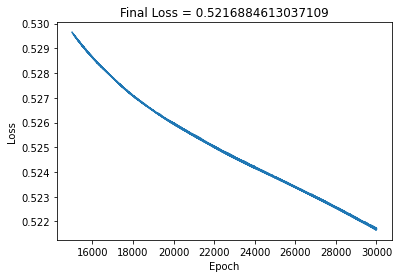

In [18]:
zoom=np.floor(len(LOSS_white)/2).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_white[-1]))

In [19]:
T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.548;
Test Accuracy is 32.035% (T=0.25);
Test Accuracy is 54.669% (T=0.5);
Test Accuracy is 85.281% (T=1);
Test KAPPA is 27.57% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

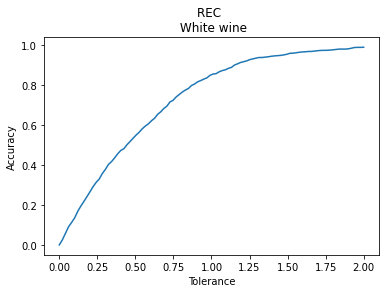

In [20]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

### Red wine

In [21]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

 20%|██        | 6140/30000 [00:05<00:23, 1027.13it/s]


 After 6000 Epochs: MAD is 0.477; Accuracy is 60.878% (T=0.5); KAPPA is 34.755% (T=0.5)


 41%|████      | 12187/30000 [00:11<00:17, 1026.72it/s]


 After 12000 Epochs: MAD is 0.468; Accuracy is 61.625% (T=0.5); KAPPA is 35.881% (T=0.5)


 61%|██████    | 18155/30000 [00:17<00:11, 1033.90it/s]


 After 18000 Epochs: MAD is 0.46; Accuracy is 62.278% (T=0.5); KAPPA is 37.073% (T=0.5)


 81%|████████  | 24155/30000 [00:23<00:05, 1027.20it/s]


 After 24000 Epochs: MAD is 0.455; Accuracy is 62.932% (T=0.5); KAPPA is 38.462% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1023.99it/s]


 After 30000 Epochs: MAD is 0.451; Accuracy is 63.119% (T=0.5); KAPPA is 38.728% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.4507947266101837')

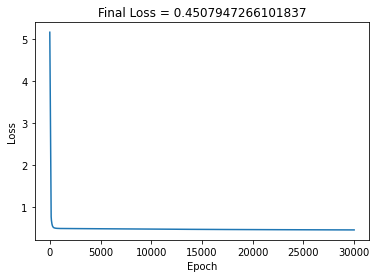

In [22]:
zoom=np.floor(len(LOSS_red)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_red[-1]))

In [23]:
T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.496;
Test Accuracy is 36.364% (T=0.25);
Test Accuracy is 57.386% (T=0.5);
Test Accuracy is 88.826% (T=1);
Test KAPPA is 30.16% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

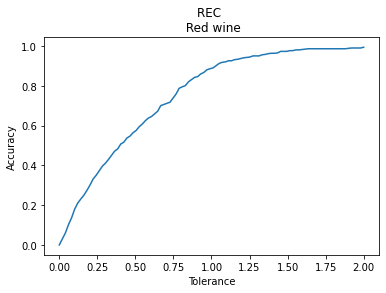

In [24]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

#  Sensitivity Analysis 
!“correlation does not equal causation.”

In [25]:
p=X_TRAIN_red.shape[1] #11

In [26]:
def Sensitivity_Analysis(MODEL,a,L=6):
    #a: indicator of the predictor, a=0,1,2,...10(p-1)
    MODEL.eval()
    Analysis_X=torch.zeros((L,p))
    Analysis_X[:,(a)]=torch.from_numpy(np.linspace(-1, 1, 6, endpoint=True))
    if train_on_gpu:
        Analysis_X=Analysis_X.to(device="cuda")
    result=MODEL(Analysis_X).var()
    MODEL.train()
    return result.cpu().detach().numpy()

In [27]:
V_red=np.zeros(p)
for a in range(p):
  V_red[a]=(Sensitivity_Analysis(MODEL_NN_red,a))
R_red=V_red/V_red.sum()*100
#R_red=pd.DataFrame(R_red,index=predictors_name)

V_white=np.zeros(p)
for a in range(p):
  V_white[a]=(Sensitivity_Analysis(MODEL_NN_white,a))
R_white=V_white/V_white.sum()*100
#R_white=pd.DataFrame(R_white,index=predictors_name)
R=pd.DataFrame({"red":R_red,"white":R_white}, index=predictors_name)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb77140f750>],
      dtype=object)

<Figure size 720x720 with 0 Axes>

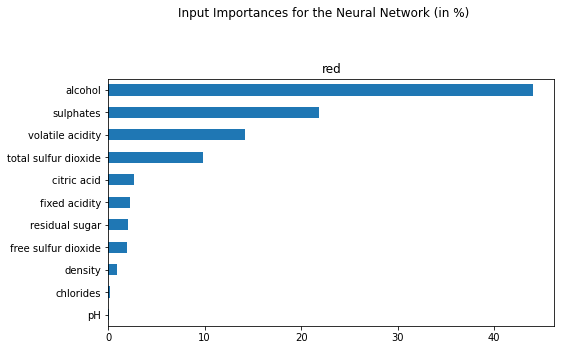

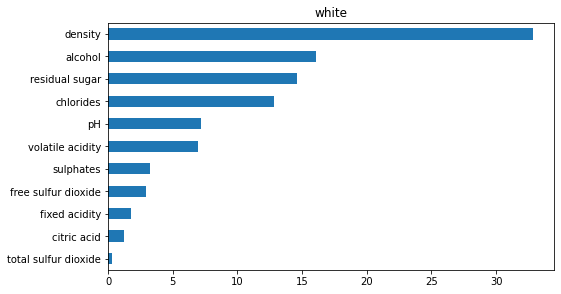

In [28]:
plt.figure(figsize=(10,10))
R.sort_values(by="red").plot.barh(y='red',legend=None,subplots=True, layout=(2,1),figsize=(8,10),title="Input Importances for the Neural Network (in %)")
R.sort_values(by="white").plot.barh(y='white',legend=None,subplots=True, layout=(2,1),figsize=(8,10))


# (Maybe don't have time?) Model Selection

# the Problem of Imbalance Data

In [29]:
for i,c in enumerate(red_class):
    print("there are {} red wine samples with the score of {}".format(len(Y_red_torch[Y_red_torch==red_class[i]]),c))
print("\n")
for i,c in enumerate(white_class):
    print("there are {} white wine samples with the score of {}".format(len(Y_white_torch[Y_white_torch==white_class[i]]),c))
   

there are 10 red wine samples with the score of 3
there are 53 red wine samples with the score of 4
there are 681 red wine samples with the score of 5
there are 638 red wine samples with the score of 6
there are 199 red wine samples with the score of 7
there are 18 red wine samples with the score of 8


there are 20 white wine samples with the score of 3
there are 163 white wine samples with the score of 4
there are 1457 white wine samples with the score of 5
there are 2198 white wine samples with the score of 6
there are 880 white wine samples with the score of 7
there are 175 white wine samples with the score of 8
there are 5 white wine samples with the score of 9


## Confusion Matrix T=0.5
Using the full data

>??? suppose T=0.5, and the predicted value is 2.5, which column of confusion matrix should we add it to, 2 or 3??

In [30]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0] 
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion 

,3,4,5,6,7,8
3,0,0,9,1,0,0
4,0,0,41,12,0,0
5,0,0,537,142,2,0
6,0,0,219,384,35,0
7,0,0,8,135,56,0
8,0,0,0,10,8,0


In [31]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0] 
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)    
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,0,1,6,13,0,0,0
4,0,9,101,52,1,0,0
5,0,8,855,585,9,0,0
6,0,0,389,1633,176,0,0
7,0,0,21,564,295,0,0
8,0,0,0,102,73,0,0
9,0,0,0,1,4,0,0


using the test data

In [32]:
red_pred=np.round(MODEL_NN_red(X_TEST_red).cpu().detach().numpy())   
red_confusion=confusion_matrix(Y_TEST_red.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion  

,3,4,5,6,7,8
3,0,0,2,0,0,0
4,0,0,13,6,0,0
5,0,0,168,48,1,0
6,0,0,84,118,11,0
7,0,0,3,50,17,0
8,0,0,0,2,5,0


In [33]:
white_pred=np.round(MODEL_NN_white(X_TEST_white).cpu().detach().numpy())   
white_confusion=confusion_matrix(Y_TEST_white.cpu().detach().numpy(), white_pred)
#white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion=pd.DataFrame(white_confusion,index=red_class,columns=red_class) 
white_confusion 

,3,4,5,6,7,8
3,0,0,2,5,0,0
4,0,3,23,20,0,0
5,0,4,266,199,3,0
6,0,0,155,514,62,0
7,0,0,9,194,101,0
8,0,0,0,33,24,0


None of the 9-point wine in the test dataset!   
In the test dataset, one of the 3-point wine is classified as 8!

## Precision for the different classes

using the full data

In [34]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

red_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,0,0
4,0,32.0755
5,78.8546,95.301
6,60.1881,96.8652
7,28.1407,75.3769
8,0,0
Overall,61.1007,89.681


In [35]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

white_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,0,0
4,5.52147,34.9693
5,58.6822,90.1853
6,74.2948,96.9063
7,33.5227,77.8409
8,0,10.2857
9,0,0
Overall,57.0029,85.831


# To fix the Problem of Imbalance data: SMOTE
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/   
  
N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal Of Artificial Intelligence Research, Volume 16, pages 321-357.
 

Using the syntheric dataset for the training/testing   
Using the original dataset to get the confusion matrices and the precision

In [36]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import statistics

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## resample only the minority class 

Need to decide the size of oversampling

?? underfitting?

### Max

In [37]:
counter = Counter(Y_white["quality"])
print(counter)
Max=max(counter.values()) #2198
sm = SMOTE(sampling_strategy={3:Max,9:Max},random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 3: 2198, 9: 2198, 5: 1457, 7: 880, 8: 175, 4: 163})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [38]:
counter = Counter(Y_red["quality"])
print(counter)
Max=max(counter.values()) 
sm = SMOTE(sampling_strategy={3:Max,8:Max,4:Max},random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 4: 681, 8: 681, 3: 681, 6: 638, 7: 199})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [39]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

 21%|██        | 6169/30000 [00:06<00:23, 995.08it/s] 


 After 6000 Epochs: MAD is 1.152; Accuracy is 35.427% (T=0.5); KAPPA is 24.936% (T=0.5)


 41%|████      | 12173/30000 [00:11<00:17, 1033.62it/s]


 After 12000 Epochs: MAD is 1.008; Accuracy is 43.913% (T=0.5); KAPPA is 33.125% (T=0.5)


 60%|██████    | 18118/30000 [00:17<00:11, 1037.54it/s]


 After 18000 Epochs: MAD is 0.878; Accuracy is 51.24% (T=0.5); KAPPA is 41.05% (T=0.5)


 81%|████████  | 24164/30000 [00:23<00:05, 1007.02it/s]


 After 24000 Epochs: MAD is 0.79; Accuracy is 52.705% (T=0.5); KAPPA is 42.603% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1031.67it/s]



 After 30000 Epochs: MAD is 0.748; Accuracy is 54.283% (T=0.5); KAPPA is 44.438% (T=0.5)
Test MAD is 0.757;
Test Accuracy is 38.705% (T=0.25);
Test Accuracy is 52.272% (T=0.5);
Test Accuracy is 71.036% (T=1);
Test KAPPA is 42.044% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

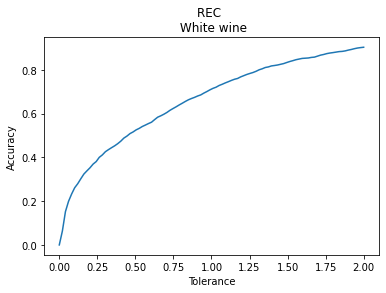

In [40]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

 20%|██        | 6115/30000 [00:06<00:23, 1024.04it/s]


 After 6000 Epochs: MAD is 0.615; Accuracy is 51.195% (T=0.5); KAPPA is 41.04% (T=0.5)


 41%|████      | 12152/30000 [00:11<00:17, 1022.14it/s]


 After 12000 Epochs: MAD is 0.583; Accuracy is 54.382% (T=0.5); KAPPA is 44.834% (T=0.5)


 60%|██████    | 18131/30000 [00:17<00:11, 1005.29it/s]


 After 18000 Epochs: MAD is 0.551; Accuracy is 56.226% (T=0.5); KAPPA is 47.006% (T=0.5)


 80%|████████  | 24114/30000 [00:23<00:05, 1039.80it/s]


 After 24000 Epochs: MAD is 0.528; Accuracy is 58.113% (T=0.5); KAPPA is 49.129% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1025.98it/s]


 After 30000 Epochs: MAD is 0.509; Accuracy is 60.839% (T=0.5); KAPPA is 52.319% (T=0.5)
Test MAD is 0.538;
Test Accuracy is 46.003% (T=0.25);
Test Accuracy is 62.755% (T=0.5);
Test Accuracy is 81.633% (T=1);
Test KAPPA is 54.447% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

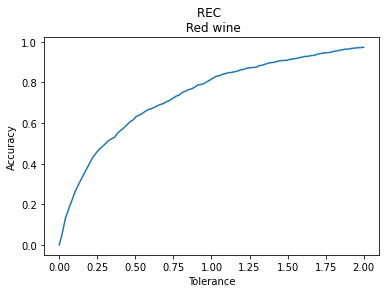

In [41]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

In [42]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion 

,3,4,5,6,7,8
3,8,2,0,0,0,0
4,15,22,11,4,0,1
5,65,236,276,74,21,9
6,19,122,190,145,90,72
7,0,9,22,33,53,82
8,0,0,0,0,5,13


In [43]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,6,4,4,2,1,3,0
4,16,63,56,18,3,7,0
5,64,314,671,282,79,47,0
6,21,172,694,723,326,262,0
7,1,26,118,265,234,236,0
8,2,8,25,39,39,62,0
9,0,0,0,0,0,5,0


In [44]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

red_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,80,100
4,41.5094,77.3585
5,40.5286,66.6667
6,22.7273,42.79
7,26.6332,49.7487
8,72.2222,100
Overall,32.3327,55.9725


In [45]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

white_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,25,40
4,38.6503,65.6442
5,46.0535,73.9876
6,32.8935,60.8735
7,26.5909,52.2727
8,17.7143,33.1429
9,0,20
Overall,35.2593,62.2703


### Median 

In [46]:
counter = Counter(Y_white["quality"])
print(counter)
median=int(statistics.median(counter.values()))#175
sm = SMOTE(sampling_strategy={3:median,9:median},random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 3: 175, 9: 175, 4: 163})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [47]:
counter = Counter(Y_red["quality"])
print(counter)
Median=int(statistics.median(counter.values()))
sm = SMOTE(sampling_strategy={3:Median,8:Median,4:Median},random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 6: 638, 7: 199, 4: 126, 8: 126, 3: 126})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

 20%|██        | 6121/30000 [00:06<00:23, 1037.50it/s]


 After 6000 Epochs: MAD is 0.704; Accuracy is 49.528% (T=0.5); KAPPA is 23.114% (T=0.5)


 40%|████      | 12118/30000 [00:11<00:17, 1038.35it/s]


 After 12000 Epochs: MAD is 0.696; Accuracy is 49.843% (T=0.5); KAPPA is 23.72% (T=0.5)


 61%|██████    | 18159/30000 [00:17<00:11, 986.92it/s]


 After 18000 Epochs: MAD is 0.683; Accuracy is 50.3% (T=0.5); KAPPA is 24.842% (T=0.5)


 80%|████████  | 24103/30000 [00:23<00:05, 1008.68it/s]


 After 24000 Epochs: MAD is 0.674; Accuracy is 50.443% (T=0.5); KAPPA is 25.291% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1014.86it/s]



 After 30000 Epochs: MAD is 0.666; Accuracy is 51.129% (T=0.5); KAPPA is 26.562% (T=0.5)
Test MAD is 0.666;
Test Accuracy is 27.552% (T=0.25);
Test Accuracy is 50.522% (T=0.5);
Test Accuracy is 79.292% (T=1);
Test KAPPA is 26.03% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

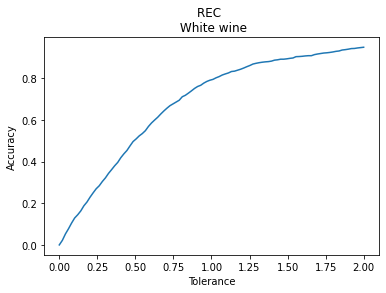

In [49]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

 21%|██        | 6200/30000 [00:06<00:23, 1013.99it/s]


 After 6000 Epochs: MAD is 0.637; Accuracy is 48.976% (T=0.5); KAPPA is 28.119% (T=0.5)


 40%|████      | 12114/30000 [00:11<00:17, 1021.97it/s]


 After 12000 Epochs: MAD is 0.618; Accuracy is 48.425% (T=0.5); KAPPA is 27.937% (T=0.5)


 60%|██████    | 18113/30000 [00:17<00:11, 1030.17it/s]


 After 18000 Epochs: MAD is 0.597; Accuracy is 50.472% (T=0.5); KAPPA is 30.98% (T=0.5)


 81%|████████  | 24160/30000 [00:23<00:05, 1034.90it/s]


 After 24000 Epochs: MAD is 0.579; Accuracy is 52.047% (T=0.5); KAPPA is 33.453% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1030.27it/s]



 After 30000 Epochs: MAD is 0.569; Accuracy is 52.992% (T=0.5); KAPPA is 34.924% (T=0.5)
Test MAD is 0.601;
Test Accuracy is 29.233% (T=0.25);
Test Accuracy is 50.16% (T=0.5);
Test Accuracy is 80.032% (T=1);
Test KAPPA is 30.826% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

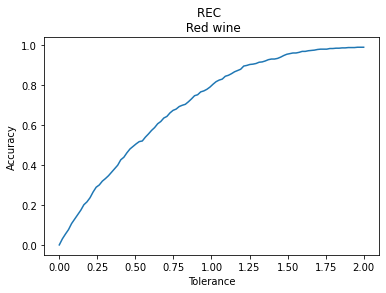

In [50]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

In [51]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion 

,3,4,5,6,7,8
3,2,6,1,1,0,0
4,1,23,22,7,0,0
5,3,66,483,116,13,0
6,2,19,216,307,90,4
7,0,1,14,85,92,7
8,0,0,0,5,11,2


In [52]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,0,2,8,9,1,0,0
4,0,10,105,47,1,0,0
5,0,15,820,589,33,0,0
6,0,2,420,1475,300,1,0
7,0,0,48,474,356,2,0
8,0,0,1,76,98,0,0
9,0,0,0,1,4,0,0


In [53]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

red_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,20,60
4,43.3962,69.8113
5,70.9251,90.7489
6,48.1191,81.8182
7,46.2312,77.3869
8,11.1111,33.3333
Overall,56.848,83.99


In [54]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

white_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,0,0
4,6.13497,33.7423
5,56.28,87.6458
6,67.1065,95.2684
7,40.4545,76.9318
8,0,13.1429
9,0,0
Overall,54.3283,84.2385


## resample all classes but the majority class

In [55]:
counter = Counter(Y_white["quality"])
print(counter)
sm = SMOTE(sampling_strategy="not majority",random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 5: 2198, 7: 2198, 8: 2198, 4: 2198, 3: 2198, 9: 2198})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [56]:
counter = Counter(Y_red["quality"])
print(counter)
sm = SMOTE(sampling_strategy="not majority",random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 6: 681, 7: 681, 4: 681, 8: 681, 3: 681})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [57]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

 21%|██        | 6153/30000 [00:05<00:23, 1029.21it/s]


 After 6000 Epochs: MAD is 1.073; Accuracy is 36.428% (T=0.5); KAPPA is 25.847% (T=0.5)


 40%|████      | 12147/30000 [00:11<00:17, 1001.69it/s]


 After 12000 Epochs: MAD is 0.973; Accuracy is 41.017% (T=0.5); KAPPA is 31.194% (T=0.5)


 60%|██████    | 18120/30000 [00:17<00:11, 1004.72it/s]


 After 18000 Epochs: MAD is 0.878; Accuracy is 44.393% (T=0.5); KAPPA is 35.129% (T=0.5)


 80%|████████  | 24144/30000 [00:23<00:05, 988.70it/s]


 After 24000 Epochs: MAD is 0.833; Accuracy is 46.508% (T=0.5); KAPPA is 37.6% (T=0.5)


100%|██████████| 30000/30000 [00:29<00:00, 1011.48it/s]



 After 30000 Epochs: MAD is 0.804; Accuracy is 47.516% (T=0.5); KAPPA is 38.778% (T=0.5)
Test MAD is 0.818;
Test Accuracy is 29.618% (T=0.25);
Test Accuracy is 46.16% (T=0.5);
Test Accuracy is 69.161% (T=1);
Test KAPPA is 37.188% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

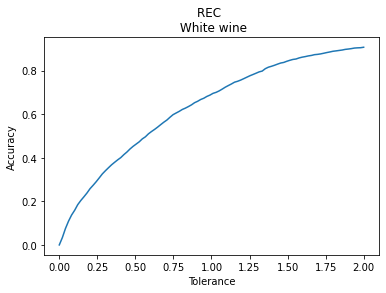

In [58]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

 20%|██        | 6136/30000 [00:05<00:22, 1049.42it/s]


 After 6000 Epochs: MAD is 0.551; Accuracy is 55.645% (T=0.5); KAPPA is 46.775% (T=0.5)


 40%|████      | 12107/30000 [00:11<00:17, 1039.72it/s]


 After 12000 Epochs: MAD is 0.477; Accuracy is 63.025% (T=0.5); KAPPA is 55.64% (T=0.5)


 60%|██████    | 18135/30000 [00:17<00:11, 1008.70it/s]


 After 18000 Epochs: MAD is 0.445; Accuracy is 66.862% (T=0.5); KAPPA is 60.234% (T=0.5)


 80%|████████  | 24109/30000 [00:23<00:05, 1015.80it/s]


 After 24000 Epochs: MAD is 0.435; Accuracy is 67.336% (T=0.5); KAPPA is 60.805% (T=0.5)


100%|██████████| 30000/30000 [00:28<00:00, 1035.02it/s]



 After 30000 Epochs: MAD is 0.427; Accuracy is 66.935% (T=0.5); KAPPA is 60.335% (T=0.5)
Test MAD is 0.488;
Test Accuracy is 44.848% (T=0.25);
Test Accuracy is 63.454% (T=0.5);
Test Accuracy is 84.952% (T=1);
Test KAPPA is 56.134% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

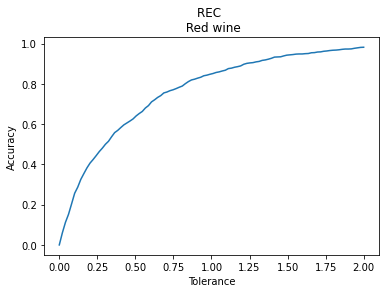

In [64]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],LR=1e-1/2,EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

In [65]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion 

,3,4,5,6,7,8
3,6,2,2,0,0,0
4,9,24,15,4,1,0
5,50,173,315,112,27,4
6,12,83,194,174,134,41
7,0,6,16,38,90,49
8,0,0,0,0,1,17


In [66]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,8,4,0,5,3,0,0
4,18,65,49,22,8,1,0
5,41,320,627,351,88,30,0
6,15,142,537,734,532,238,0
7,0,11,76,171,343,279,0
8,0,3,10,29,58,75,0
9,0,0,0,0,0,5,0


In [67]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

red_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,60,80
4,45.283,81.1321
5,46.2555,73.2746
6,27.2727,57.9937
7,45.2261,74.8744
8,88.8889,100
Overall,39.0869,67.98


In [68]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

white_precision.append(overall)

,T=0.5 (%),T=1.0 (%)
3,40,50
4,39.8773,71.7791
5,43.0336,70.6932
6,33.394,62.1929
7,38.9773,65.4545
8,37.7143,62.8571
9,80,80
Overall,37.7093,65.6186


# To Be Continuted Conclusion

The Neural Network architecture is sick